In [76]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trace']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Question 1
Recall the globe tossing model from chapter 2.

# A
Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for $p$.
  1. W,W,W
  2. W,W,W,L
  3. L,W,W,L,W,W,W

# B
Now assume a prior for $p$ that is equal to zero when $p < 0.5$ and is a positive constant when $p \geq 0.5$. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.

# C
Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes (you don't know which) was tossed in the air and produced a "land" observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing "land" (${\rm Pr}(\text{Earth} | \text{land})$), is 0.23.

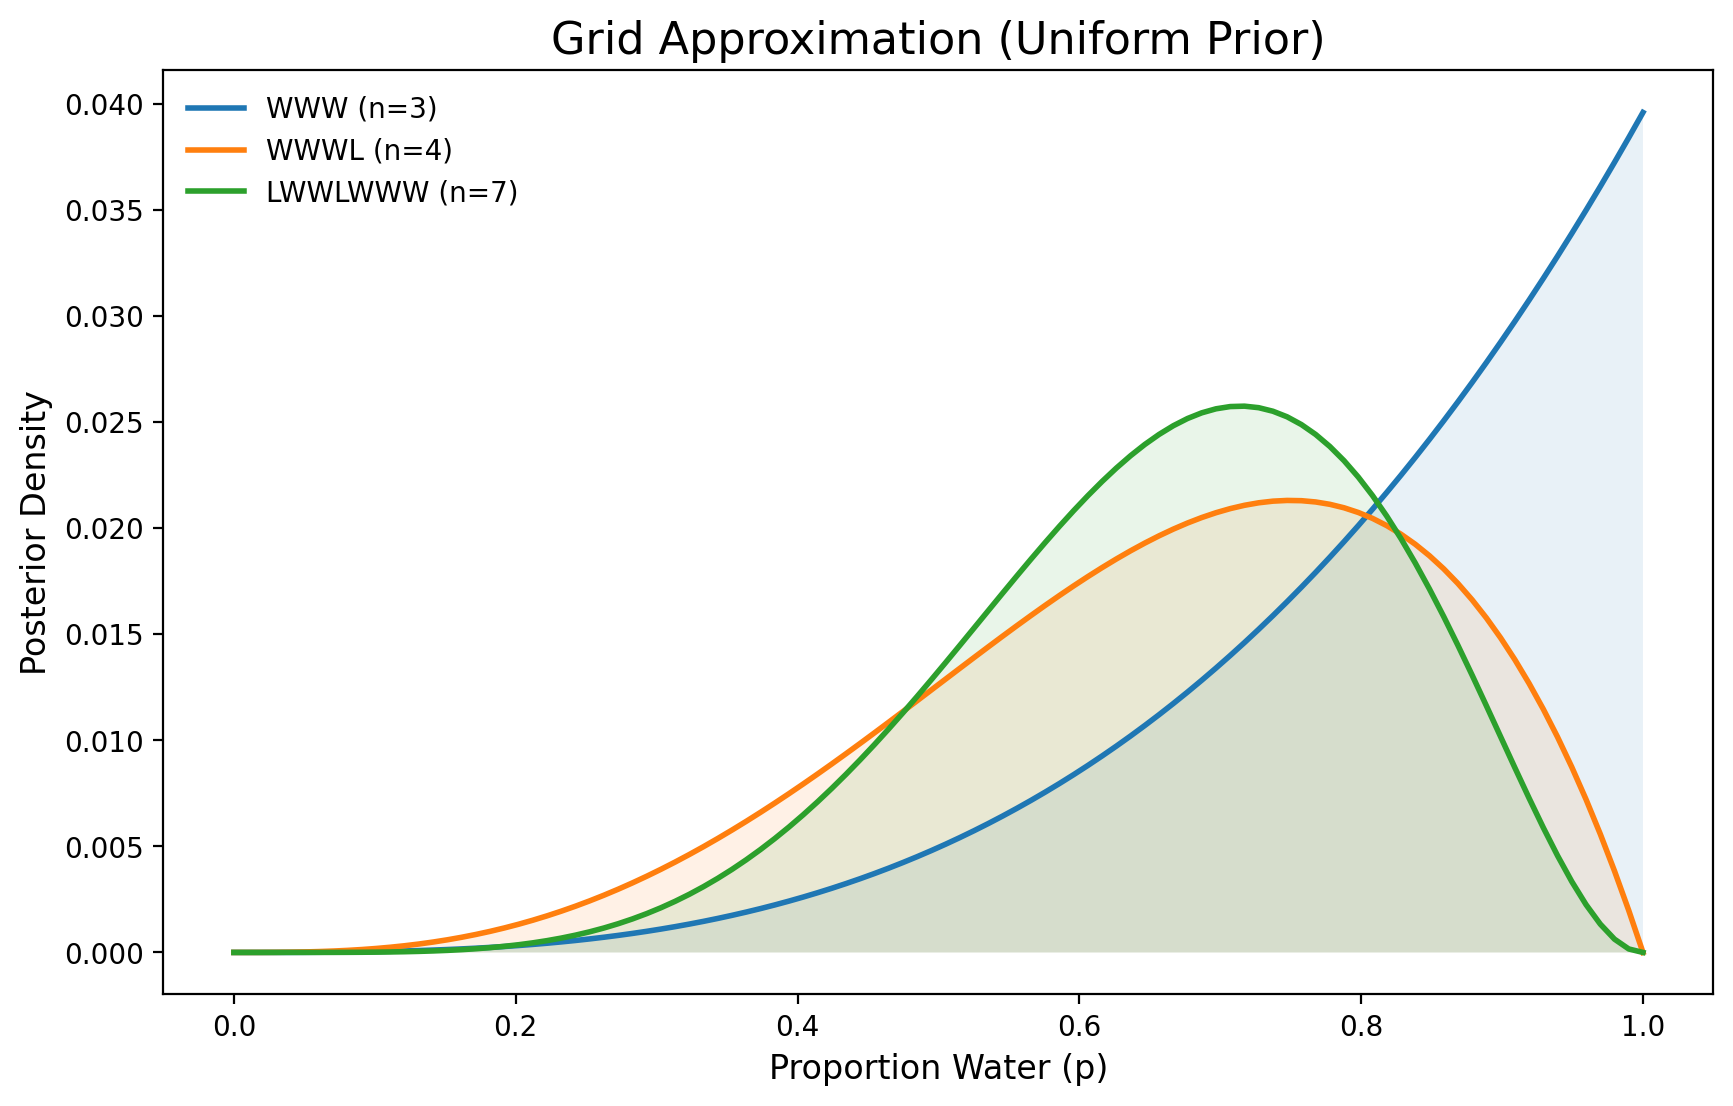

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Define datasets
datasets = [
    {'label': 'WWW', 'w': 3, 'n': 3},
    {'label': 'WWWL', 'w': 3, 'n': 4},
    {'label': 'LWWLWWW', 'w': 5, 'n': 7}
]

# Grid approximation
plt.figure(figsize=(10, 6))
grid_points = 100
p_grid = np.linspace(0, 1, grid_points)

for dataset in datasets:
    likelihood = binom.pmf(dataset['w'], dataset['n'], p_grid)
    prior = np.ones_like(p_grid) / grid_points
    posterior = likelihood * prior
    posterior /= posterior.sum()

    plt.plot(p_grid, posterior, label=f"{dataset['label']} (n={dataset['n']})", lw=2)
    plt.fill_between(p_grid, posterior, alpha=0.1)

plt.title('Grid Approximation (Uniform Prior)', fontsize=16)
plt.xlabel('Proportion Water (p)', fontsize=12)
plt.ylabel('Posterior Density', fontsize=12)
plt.legend(fontsize=10, frameon=False)
plt.show()


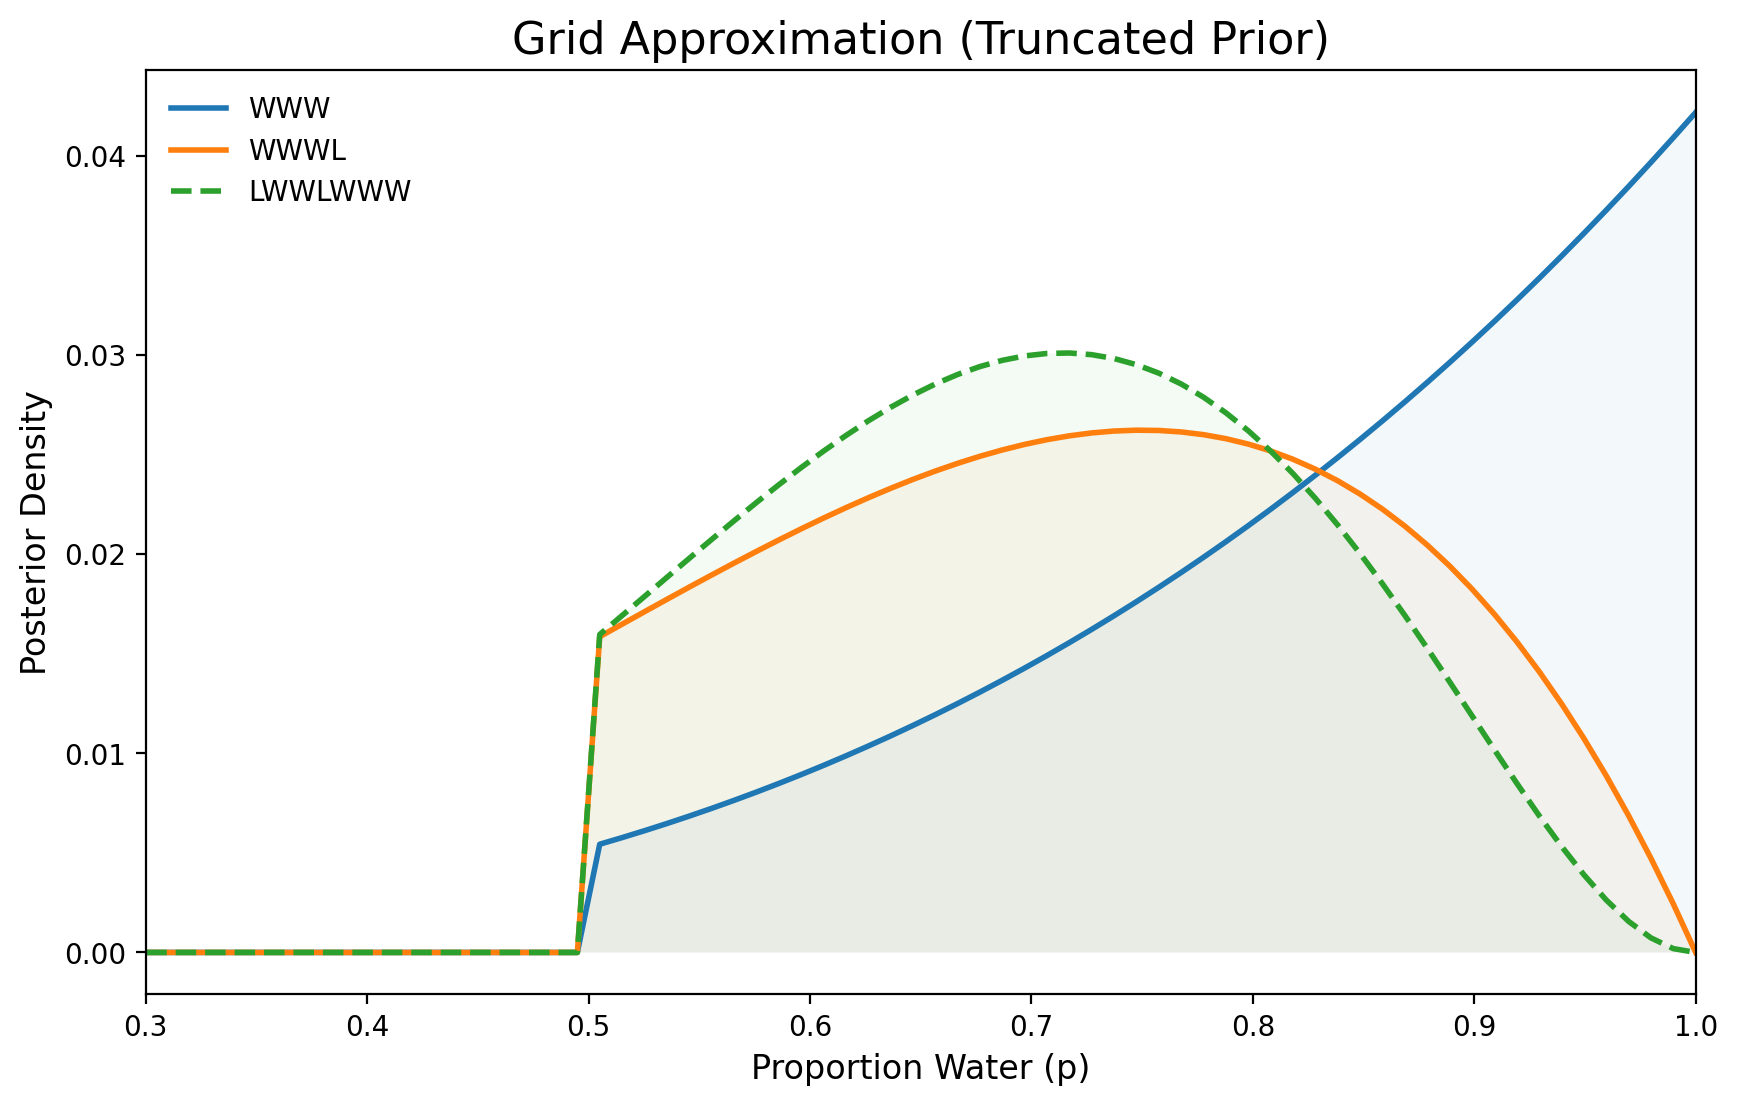

In [78]:
# Define truncated prior function
def truncated_prior(grid):
    prior = np.zeros_like(grid)
    mask = grid >= 0.5
    prior[mask] = 1 / (grid[mask].size / grid.size)  # Normalize to sum to 1
    return prior

plt.figure(figsize=(10, 6))

for dataset in datasets:
    likelihood = binom.pmf(dataset['w'], dataset['n'], p_grid)
    prior = truncated_prior(p_grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()

    plt.plot(p_grid, posterior, label=f"{dataset['label']}", lw=2,
             linestyle='--' if dataset['n'] == 7 else '-')
    plt.fill_between(p_grid, posterior, alpha=0.05)

plt.title('Grid Approximation (Truncated Prior)', fontsize=16)
plt.xlabel('Proportion Water (p)', fontsize=12)
plt.ylabel('Posterior Density', fontsize=12)
plt.legend(fontsize=10, frameon=False)
plt.xlim(0.3, 1)  # Focus on the key region
plt.show()

In [79]:
import pymc as pm
with pm.Model() as planet_model:
    is_earth = pm.Bernoulli('is_earth', p=0.5)
    p_land = pm.math.switch(is_earth, 0.3, 1.0)
    obs = pm.Bernoulli('obs', p=p_land, observed=1)
    trace = pm.sample(3000, tune=1500, random_seed=892)
# Compute posterior probability
earth_samples = trace.posterior['is_earth'].values.flatten()
earth_prob = np.mean(earth_samples)
print(f'''
Bayesian theorem analytical solution:
P(Earth | Land) = (0.3 * 0.5) / (0.3 * 0.5 + 1.0 * 0.5) = {0.15 / 0.65:.4f}''')
print(f"Pr(Earth | Land) = {earth_prob:.2f} (n={len(earth_samples)} samples)")

Output()

Output()


Bayesian theorem analytical solution:
P(Earth | Land) = (0.3 * 0.5) / (0.3 * 0.5 + 1.0 * 0.5) = 0.2308
Pr(Earth | Land) = 0.23 (n=6000 samples)


# Question 2
Suppose that in a certain region there are two species of polar bear (the two species cannot interbreed). Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic test capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 8% of the time, otherwise birthing a single infant. Species B births twins 19% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research.

# A
Now suppose you are managing a captive polar bear breeding program. You have a new female bear of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?

# B
Now compute the probability that the bear we have is from species A, assuming we have observed only the first birth and that it was twins.

# C
suppose the same mother bear mother has a second birth and that it is not twins, but a singleton infant. Compute the posterior probability that she is species A.


In [80]:
import numpy as np

# Set random seed
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

# Prior probabilities
P_A = 0.5
P_B = 0.5

# Likelihoods
P_twins_A = 0.08  # Probability of twins in species A
P_twins_B = 0.19  # Probability of twins in species B

# Compute posterior probability P(A | T) using Bayes' theorem
P_A_given_twins = (P_twins_A * P_A) / ((P_twins_A * P_A) + (P_twins_B * P_B))

# Compute updated probability of next birth being twins
P_twins_next = (P_twins_A * P_A_given_twins) + (P_twins_B * (1 - P_A_given_twins))

print(f"Probability of next birth being twins: {P_twins_next:.4f}")

Probability of next birth being twins: 0.1574


In [81]:
# Compute posterior probability using Bayes' theorem
P_A_given_twins = (P_twins_A * P_A) / ((P_twins_A * P_A) + (P_twins_B * P_B))

print(f"Probability that the bear is species A given first birth was twins: {P_A_given_twins:.4f}")

Probability that the bear is species A given first birth was twins: 0.2963


In [82]:
# Likelihoods for singleton births
P_single_A = 1 - P_twins_A
P_single_B = 1 - P_twins_B

# Update prior with the first observation (twins)
P_A_updated = P_A_given_twins
P_B_updated = 1 - P_A_updated

# Compute posterior probability after observing a singleton birth
P_A_given_twins_and_single = (P_single_A * P_A_updated) / (
    (P_single_A * P_A_updated) + (P_single_B * P_B_updated)
)

print((
    f"Posterior probability that the bear is species A given first birth was twins\n"
    f"and second birth was singleton: {P_A_given_twins_and_single:.4f}"
))

Posterior probability that the bear is species A given first birth was twins
and second birth was singleton: 0.3235
